In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [3]:
from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"
HTML(style)

In [4]:
titanic_data = pd.read_csv("train.csv")

In [5]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
Y = titanic_data.Survived

In [8]:
X = pd.get_dummies(X)

In [9]:
X = X.fillna({'Age' : X.Age.median()})

In [10]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [11]:
clf.fit(X, Y)

DecisionTreeClassifier(criterion='entropy')

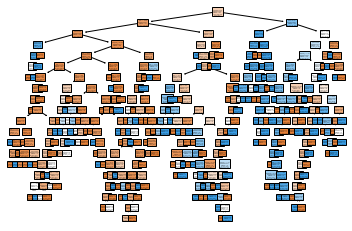

In [12]:
tree.plot_tree(clf, feature_names=list(X),
               class_names=['Died', 'Survived'],
               filled=True);

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)

In [15]:
clf.score(X, Y)

0.9797979797979798

In [16]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [17]:
clf.score(X_train, y_train)

0.9798657718120806

In [18]:
clf.fit(X_test, y_test)

DecisionTreeClassifier(criterion='entropy')

In [19]:
clf.score(X_test, y_test)

1.0

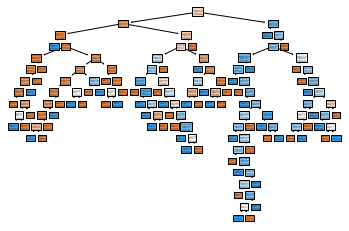

In [20]:
tree.plot_tree(clf, feature_names=list(X),
               class_names=['Died', 'Survived'],
               filled=True);

In [21]:
max_depth_values = range(1, 100)

In [22]:
scores_data = pd.DataFrame()

In [23]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    temp_score_data = pd.DataFrame({'max_depth' : [max_depth], 
                                    'train_score' : [train_score], 
                                    'test_score' : [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [24]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.810169


In [25]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'],
                          var_name='set_type', value_name='score')

In [26]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


<AxesSubplot:xlabel='max_depth', ylabel='score'>

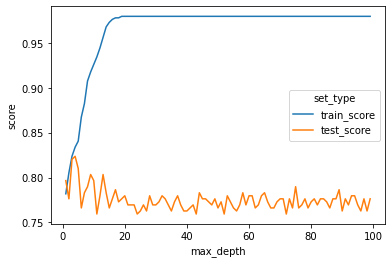

In [27]:
sns.lineplot(data=scores_data_long, x='max_depth', y='score', hue='set_type')

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}

In [30]:
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=5)

In [31]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=99),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [32]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 12}

In [33]:
best_clf = grid_search_cv_clf.best_estimator_

In [34]:
best_clf.score(X_test, y_test)

0.7728813559322034

In [35]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [36]:
precision_score(y_test, best_clf.predict(X_test))

0.7523809523809524

In [37]:
recall_score(y_test, best_clf.predict(X_test))

0.6583333333333333

In [38]:
y_predicted_prob = best_clf.predict_proba(X_test)

<AxesSubplot:>

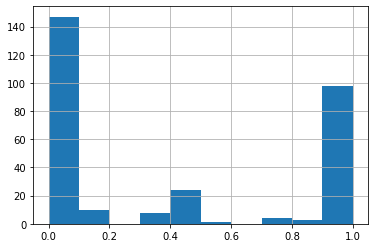

In [39]:
pd.Series(y_predicted_prob[:, 1]).hist()

In [40]:
import numpy as np

In [41]:
y_pred = np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)

<AxesSubplot:>

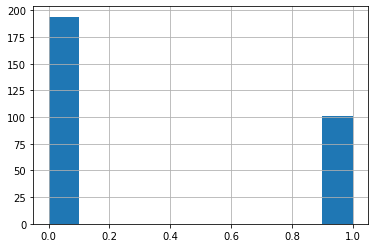

In [42]:
pd.Series(np.where(y_predicted_prob[:, 1] > 0.8, 1, 0)).hist()

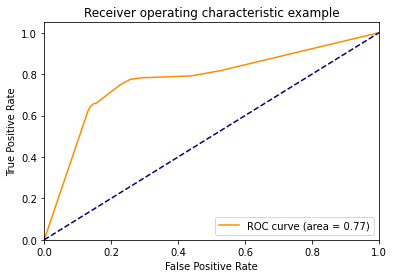

In [43]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [44]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)

In [45]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

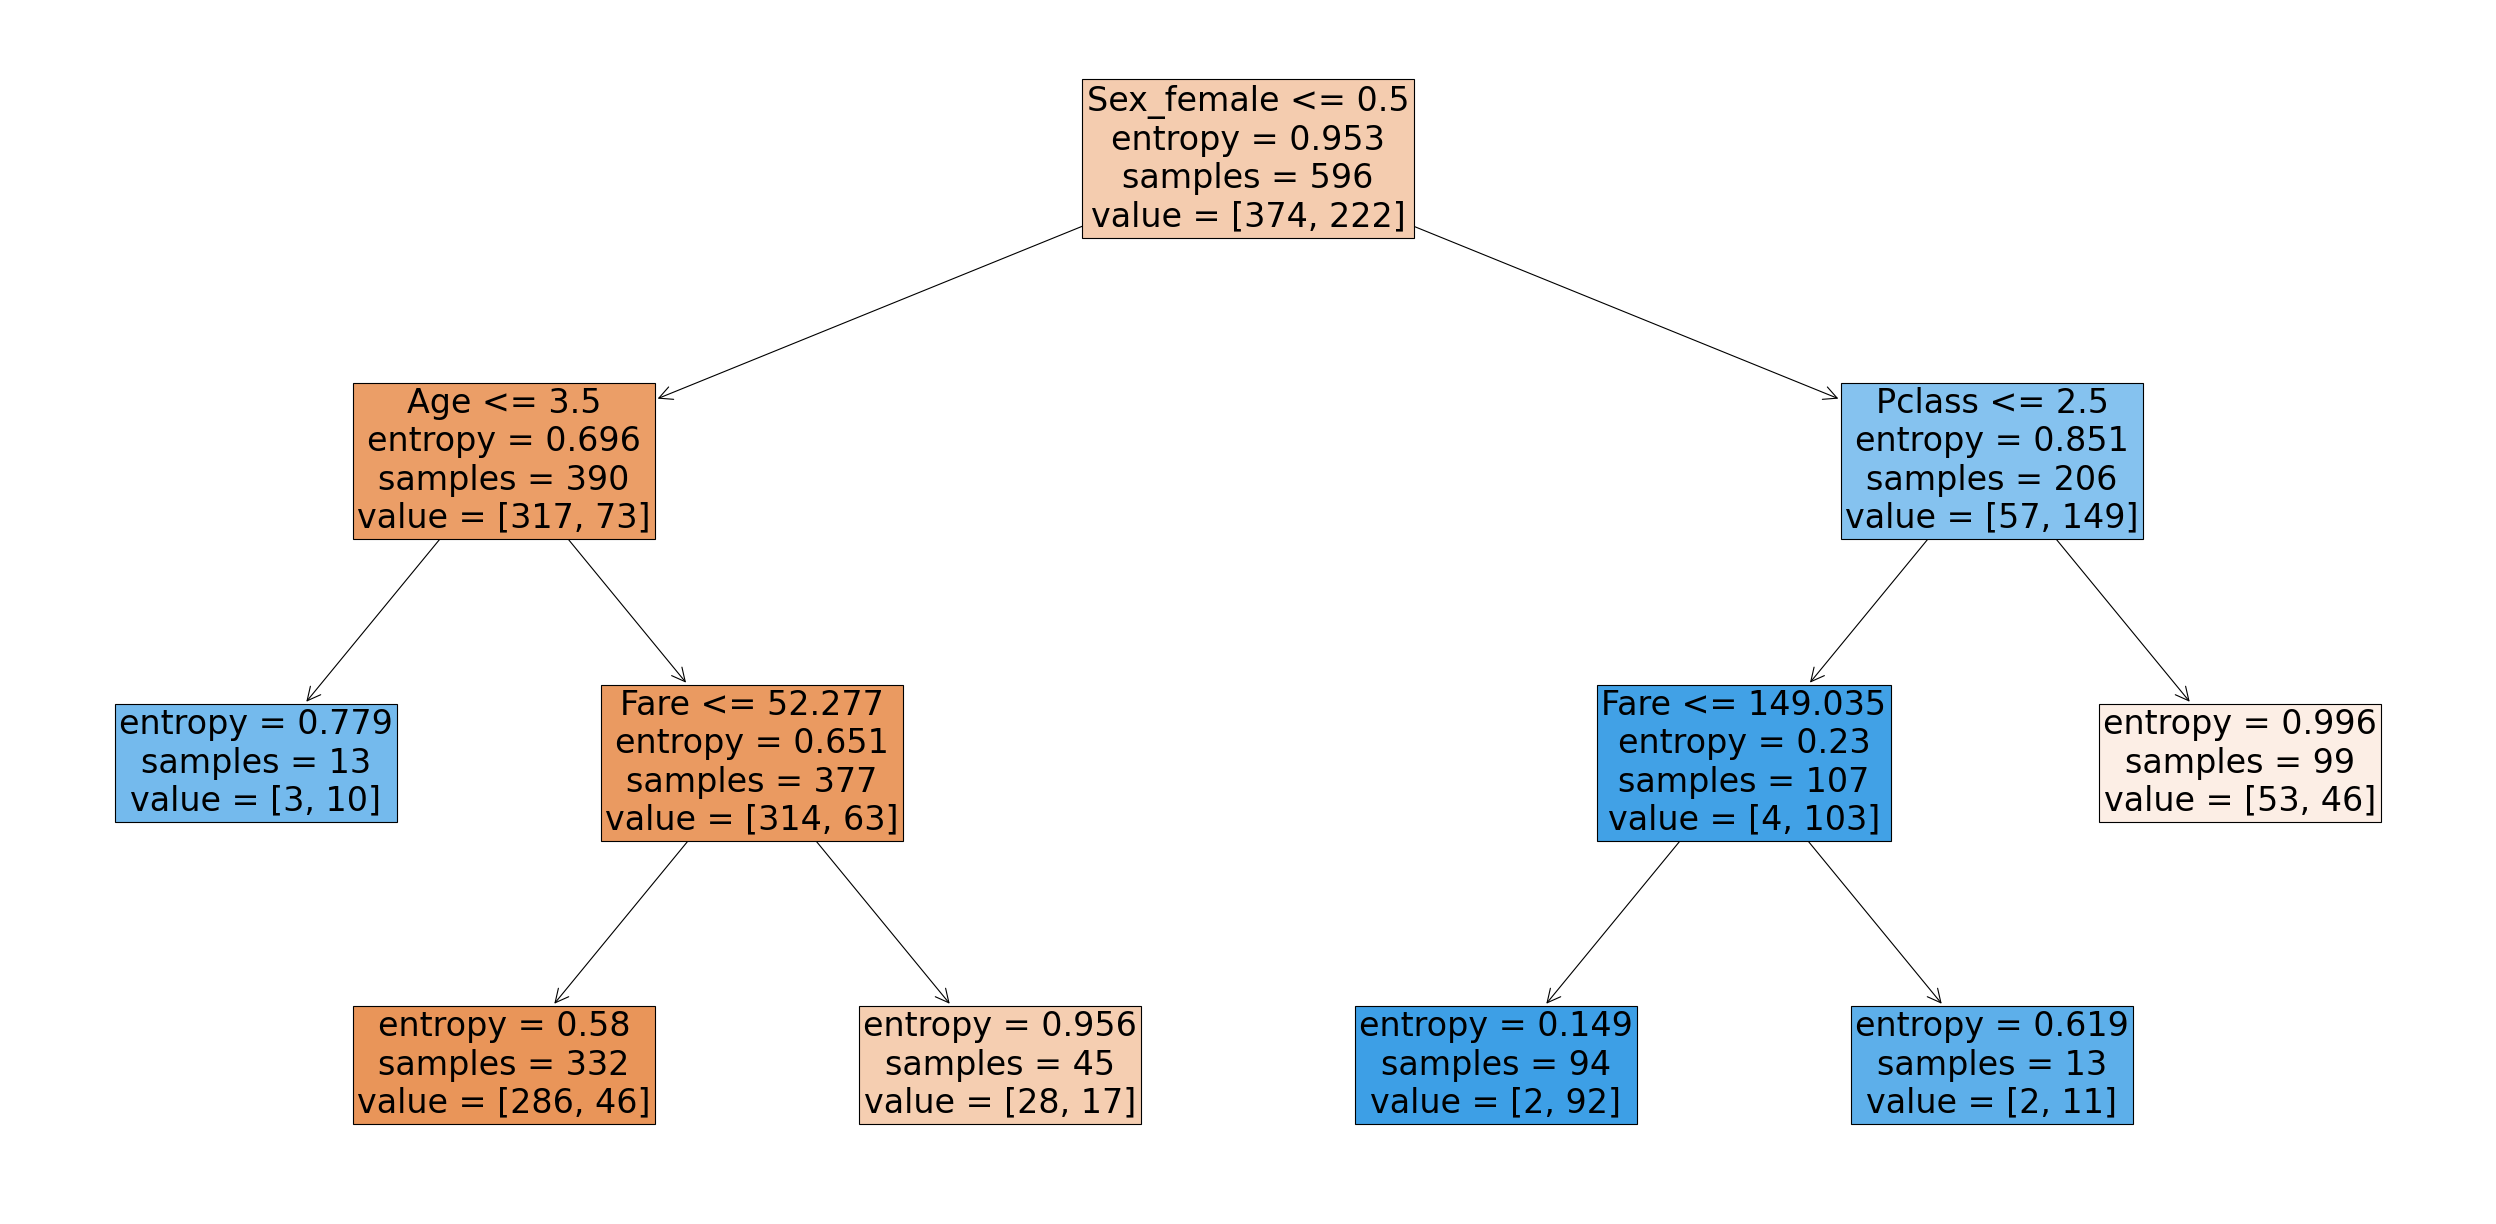

In [46]:
plt.figure(figsize=(40, 20),dpi=80)
p = tree.plot_tree(clf, fontsize=30,filled=True,feature_names=list(X))

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
clf_rf = RandomForestClassifier()

In [49]:
params = {'n_estimators' : [10, 20 ,30], 'max_depth' : [2, 5, 7, 10]}

In [50]:
grid_search_cv_clf = GridSearchCV(clf_rf, params, cv=5)

In [51]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]})

In [52]:
grid_search_cv_clf.best_params_

{'max_depth': 5, 'n_estimators': 20}

In [53]:
best_clf = grid_search_cv_clf.best_estimator_

In [55]:
best_clf.score(X_test, y_test)

0.8067796610169492

In [56]:
feature_importances = best_clf.feature_importances_

In [58]:
feature_importances_df = pd.DataFrame({
    'features' : list(X_train),
    'feature_importances' : feature_importances})

In [60]:
feature_importances_df.sort_values('feature_importances', ascending=False)

,features,feature_importances
5,Sex_female,0.313108
6,Sex_male,0.193796
4,Fare,0.144826
0,Pclass,0.122474
1,Age,0.106836
3,Parch,0.039969
2,SibSp,0.034099
9,Embarked_S,0.019239
7,Embarked_C,0.017195
8,Embarked_Q,0.008459
